mf6adj box example

In this notebook, we will test MF6ADJ using a simple box problem and compare the result with analytical solution

In [1]:
import os
import pathlib as pl
import platform
import shutil
import sys
from datetime import datetime

import flopy
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyemu

try:
    import mf6adj
except ImportError:
    sys.path.insert(0, str(pl.Path("../").resolve()))
    import mf6adj

First we need to get the platform-specific binaries. We have some strict control over these and they are stored at the root level in the repo in the bin dir. Let's workout what path we should be using and the binary names we need:

In [2]:
if "linux" in platform.platform().lower():
    lib_name = os.path.join("..", "bin", "linux", "libmf6.so")
    mf6_bin = os.path.join("..", "bin", "linux", "mf6")
    local_lib_name = "./libmf6.so"
    local_mf6_bin = "./mf6"
    gg_bin = os.path.join("..", "bin", "linux", "gridgen")
elif "darwin" in platform.platform().lower() or "macos" in platform.platform().lower() and "arm" not in platform.platform().lower():
    lib_name = os.path.join("..", "bin", "mac", "libmf6.dylib")
    mf6_bin = os.path.join("..", "bin", "mac", "mf6")
    local_lib_name = "./libmf6.dylib"
    local_mf6_bin = "./mf6"
    gg_bin = os.path.join("..", "bin", "mac", "gridgen")
elif "darwin" in platform.platform().lower() or "macos" in platform.platform().lower() and "arm" in platform.platform().lower():
    lib_name = os.path.join("..", "bin", "mac", "libmf6_arm.dylib")
    mf6_bin = os.path.join("..", "bin", "mac", "mf6")
    local_lib_name = "./libmf6_arm.dylib"
    local_mf6_bin = "./mf6"
    gg_bin = os.path.join("..", "bin", "mac", "gridgen")
else:
    lib_name = os.path.join("..", "bin", "win", "libmf6.dll")
    mf6_bin = os.path.join("..", "bin", "win", "mf6.exe")
    local_lib_name = "libmf6.dll"
    local_mf6_bin = "mf6.exe"
    gg_bin = os.path.join("..", "bin", "win", "gridgen.exe")

In [3]:
env_path = pl.Path(r"..\bin").resolve()
assert env_path is not None, "Notebook must be run from the mf6adj Conda environment"

In [4]:
bin_path = "bin"
exe_ext = ""
if "linux" in platform.platform().lower():
    lib_ext = ".so"
elif "darwin" in platform.platform().lower() or "macos" in platform.platform().lower():
    lib_ext = ".dylib"
else:
    bin_path = "Scripts"
    lib_ext = ".dll"
    exe_ext = ".exe"
lib_name = env_path / f"{bin_path}/libmf6{lib_ext}"
mf6_bin = env_path / f"{bin_path}/mf6{exe_ext}"

Now let's get the model files we will be using - they are stored in the autotest directory (here names as: xd_box_chd_ana)

In [5]:
org_ws = os.path.join("..", "autotest", "xd_box_chd_ana")
assert os.path.exists(org_ws)

setup a local copy of the model files. Also copy in the binaries we need for later....

In [6]:
ws = "xd_box_chd_ana"
if os.path.exists(ws):
    shutil.rmtree(ws)
shutil.copytree(org_ws, ws)

'xd_box_chd_ana'

In [7]:
sim = flopy.mf6.MFSimulation.load(sim_ws=ws)
m = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package sto...
    loading package chd...
    loading package wel...
    loading package oc...
    loading package npf...
  loading solution package xdbox...


In [8]:
ib = m.dis.idomain.array[0,:,:].astype(float)
ib[ib>0] = np.nan
ib_cmap = plt.get_cmap("Greys_r")
ib_cmap.set_bad(alpha=0.0)
def plot_model(arr,units=None):
    arr[~np.isnan(ib)] = np.nan
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    cb = ax.imshow(arr,cmap="plasma")
    plt.colorbar(cb,ax=ax,label=units)
    plt.imshow(ib,cmap=ib_cmap)
    return fig,ax

Run the existing model in our local workspace


In [9]:
print(local_mf6_bin)
print(os.path.exists(local_mf6_bin))
print(ws)
print(os.listdir(ws))
pyemu.os_utils.run(local_mf6_bin,cwd=ws)

mf6.exe
False
xd_box_chd_ana
['lamb_Analytical.txt', 'mfsim.nam', 'xdbox.cbb', 'xdbox.chd', 'xdbox.dis', 'xdbox.dis.grb', 'xdbox.hds', 'xdbox.ic', 'xdbox.ims', 'xdbox.lst', 'xdbox.nam', 'xdbox.npf', 'xdbox.oc', 'xdbox.sto', 'xdbox.tdis', 'xdbox.wel']
mf6.exe


Now plot some heads...

Text(0.5, 1.0, 'layer 1 final heads')

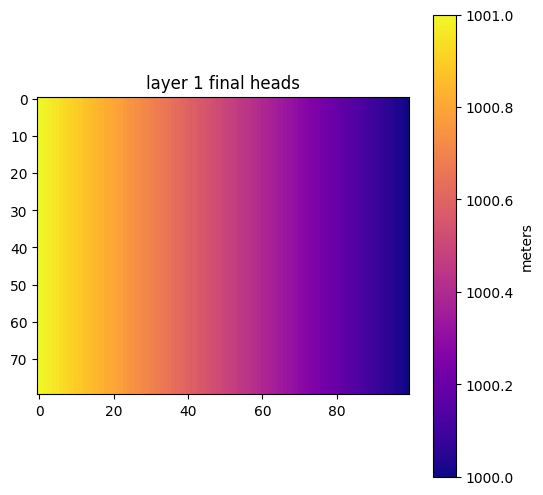

In [10]:
hds = flopy.utils.HeadFile(os.path.join(ws, "xdbox.hds"))
final_arr = hds.get_data()
fig, ax = plot_model(final_arr[0, :, :], units="meters")
ax.set_title("layer 1 final heads")

The main requirement to use Mf6Adj is an input file that describes the performance measures. Luckily this file has a nice modern format like other MF6 input files.


In [11]:
pm_fname = "xdbox.dat"
fpm = open(os.path.join(ws,pm_fname),'w')

In [12]:
l,r,c = 1,41,21 # the layer row and column
sp,ts = 1,1 #stress period and time step
pm_name = "pm_single"
fpm.write("begin performance_measure {0}\n".format(pm_name))
fpm.write("{0} {1} {2} {3} {4} head direct 1.0 -1e30\n".format(sp,ts,l,r,c))
fpm.write("end performance_measure\n\n")
fpm.close()

Ok, now we should be ready to go...the adjoint solution process requires running the model forward once and then solving for the adjoint state, which uses the forward solution components (i.e. the conductance matrix, the RHS, heads, saturation,etc). The adjoint state solution has two important characteristics: its a linear (independent of the forward model's linearity) and it solves backward in time, starting with the last stress period - WAT?!

In [13]:
bd = os.getcwd()
os.chdir(ws)

In [16]:
forward_hdf5_name = "forward.hdf5"
start = datetime.now()
import mf6adj
adj = mf6adj.Mf6Adj(pm_fname, lib_name, verbose_level=2)
adj.solve_gwf(hdf5_name=forward_hdf5_name) # solve the standard forward solution
dfsum = adj.solve_adjoint() # solve the adjoint state for each performance measure
adj.finalize() #release components
duration = (datetime.now() - start).total_seconds()
print("took:",duration)

2025-05-28 10:48:46.740889 adjoint solve took: 0.261718 for pm pm_single at kperkstp (np.int32(0), np.int32(0))
took: 0.746119


In [17]:
os.chdir(bd)

Let's see what happened...

In [18]:
[f for f in os.listdir(ws) if f.endswith("hdf5")]

['adjoint_solution_pm_single_forward.hdf5', 'forward.hdf5']

MF6ADJ uses the widely available HDF5 format to store information - these files hold very low-level granular information about the adjoint solution. However the mf6adj.solve_adjoint() method also returns a higher-level summary of the adjoint solution. Let's look at it first:

In [19]:
type(dfsum)

dict

In [20]:
list(dfsum.keys())

['pm_single']

In [21]:
dfhw = dfsum["pm_single"]
dfhw

,k11,k33,wel6_q,rch6_recharge,ss
node,,,,,
1,0.000003,0.0,0.000000,0.000000,0.000000
2,0.000005,0.0,0.000543,0.000543,-0.000066
3,0.000005,0.0,0.001084,0.001084,-0.000130
4,0.000005,0.0,0.001622,0.001622,-0.000190
5,0.000005,0.0,0.002156,0.002156,-0.000247
...,...,...,...,...,...
7996,-0.000002,0.0,0.000959,0.000959,0.000110
7997,-0.000002,0.0,0.000719,0.000719,0.000084
7998,-0.000002,0.0,0.000480,0.000480,0.000057


those are the node-scale sensitivities to the sfr flux-based performance measure - some plots would be nice you say?! Well this is most easily done with the HDF5 file itself...

In [22]:
result_hdf = "adjoint_solution_pm_single_forward.hdf5"
hdf = h5py.File(os.path.join(ws,result_hdf),'r')
keys = list(hdf.keys())
keys.sort()
print(keys)

['composite', 'solution_kper:00000_kstp:00000']


The "composite" group has the sensitivities of the performance measure to the model inputs summed across all adjoint solutions...

In [23]:
grp = hdf["composite"]
plot_keys = [i for i in grp.keys() if len(grp[i].shape) == 3]
plot_keys
grp['wel6_q'][:]

array([[[0.        , 0.00054254, 0.0010837 , ..., 0.00047285,
         0.00023644, 0.        ],
        [0.        , 0.00054393, 0.00108647, ..., 0.00047291,
         0.00023647, 0.        ],
        [0.        , 0.00054671, 0.00109203, ..., 0.00047304,
         0.00023653, 0.        ],
        ...,
        [0.        , 0.00057099, 0.00114049, ..., 0.0004798 ,
         0.00023991, 0.        ],
        [0.        , 0.00056802, 0.00113457, ..., 0.0004797 ,
         0.00023986, 0.        ],
        [0.        , 0.00056654, 0.00113162, ..., 0.00047964,
         0.00023983, 0.        ]]], shape=(1, 80, 100))

A simple routine to plot all these sensitivities....

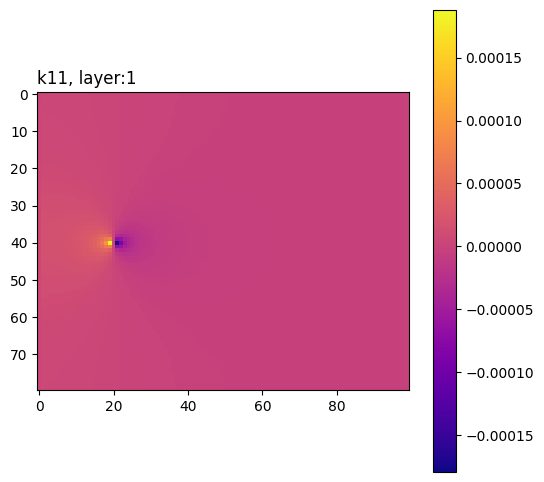

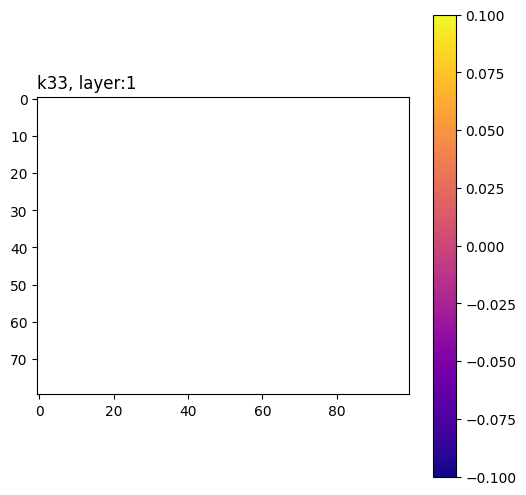

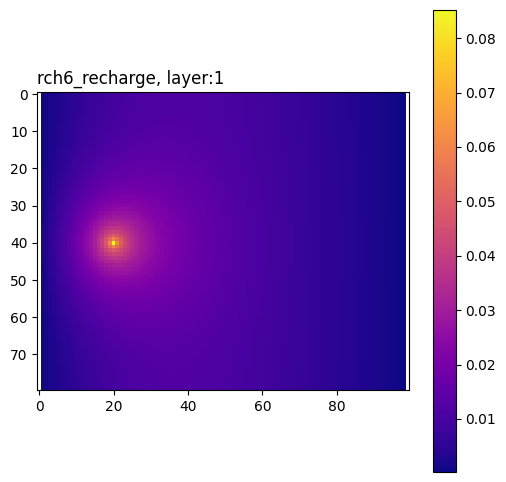

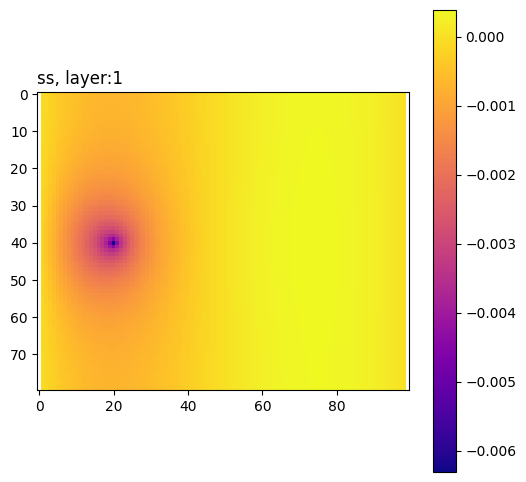

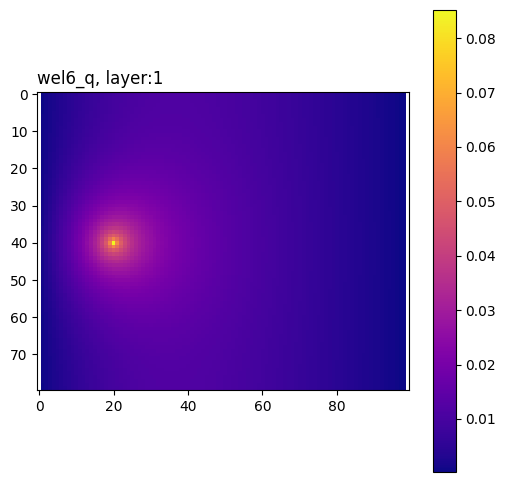

In [24]:
for pkey in plot_keys:
    arr = grp[pkey][:]
    for k,karr in enumerate(arr):
        karr[karr==0.0] = np.nan
        fig,ax = plot_model(karr)
        ax.set_title(pkey+", layer:{0}".format(k+1),loc="left")

Defining the analytical solution (Lu and Vesselinov, WRR, 2015: doi:10.1002/2014WR016819) 

In [25]:
H1, H2 = 1001., 1000. # Heads at both sides
L1, L2 = 500., 400.   # Domain size
nlay, nrow, ncol = m.dis.nlay.data, m.dis.nrow.data, m.dis.ncol.data
delrow, delcol = m.dis.delr.data[0], m.dis.delc.data[0]
L1 = delrow * ncol
L2 = delcol * nrow
H = 1.0
k = 10.0    # Hydraulic conductivity
T = k * H   # Transmissivity
D = L1 * L2

def alpha(m):
    return m * np.pi / L1

def beta(n):
    return n * np.pi / L2

def omega_square(m, n):
    return (alpha(m)) ** 2 + (beta(n)) ** 2

def phi_s(x, y, xs, ys, M=5, N=5):
    listofmindices = [item + 1 for item in range(M)]
    Sum = 0.0
    a = [0.5]
    for i in [item + 1 for item in range(N)]:
        a.append(1.0)
    for n in range(N+1):
        for m in listofmindices:
            Sum = Sum + a[n] * np.sin(alpha(m) * x) * np.cos(beta(n) * y) * np.sin(alpha(m) * xs) * np.cos(beta(n) * ys) / omega_square(m, n)
    Sum = (4 / (T*D)) * Sum
    return Sum

def get_analytical_adj_state(xs, ys, M, N):
    list_adj_state = []
    for j in range(nrow):
        for i in range(ncol):
            x = m.modelgrid.xcellcenters[j][i]
            y = m.modelgrid.ycellcenters[j][i]
            list_adj_state.append(phi_s(x, y, xs, ys, M=M, N=N))
    array_adj_state = np.array(list_adj_state)
    print("array_adj_state = ", array_adj_state)
    filepath = os.path.join(ws, "lamb_Analytical.txt")
    with open (filepath,'w') as file:
    #with open('lamb_Analytical.txt', 'w') as file:
        for value in array_adj_state:
            file.write(f"{value}\n")
    array_adj_state_2D = np.reshape(array_adj_state, (nrow, ncol))
    return array_adj_state_2D

In [26]:
def plot_colorbar_contour(x, y, l_anal, l_num, vmin, vmax):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
    ax = axes[0]
    ax.set_title("Analytical", fontsize=16)
    cs = ax.contourf(x, y, l_anal, zorder=1, vmin=vmin, vmax=vmax)
    ax.contour(cs, colors='k', linewidths=1.0,linestyles = '-')
    plt.colorbar(cs)
    ax.set_xlabel("x (m)", fontsize=14)
    ax.set_ylabel("y (m)", fontsize=14)
    ax.text(-60., 420.0, "a", weight='bold', fontsize=18)
    plt.sca(ax)
    plt.xticks([0, 100, 200, 300, 400, 500], ['0', '1000', '2000', '3000', '4000', '5000'])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400], ['0', '500', '1000', '1500', '2000', '2500', '3000', '3500', '4000'])
    ax = axes[1]
    ax.set_title("MF6-ADJ", fontsize=16)
    cs = ax.contourf(x, y, l_num, zorder=1, vmin=vmin, vmax=vmax,levels=cs.levels)
    ax.contour(cs, colors='k', linewidths=1.0,linestyles = '-')
    plt.colorbar(cs)
    ax.set_xlabel("x (m)", fontsize=14)
    ax.set_ylabel("y (m)", fontsize=14)
    ax.text(-60., 420.0, "b", weight='bold', fontsize=18)
    plt.sca(ax)
    plt.xticks([0, 100, 200, 300, 400, 500], ['0', '1000', '2000', '3000', '4000', '5000'])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400], ['0', '500', '1000', '1500', '2000', '2500', '3000', '3500', '4000'])

In [31]:
lam_anal = get_analytical_adj_state(100., 200., M=100, N=100) # M & N should be large enough to get convergence of the analytical series solution (e.g., M=N=100)
file_path = os.path.join(ws, "lamb_Analytical.txt")
with open(file_path, 'r') as file:
    lamb_ana = [float(line.strip()) for line in file]
    lamb_ana = np.array(lamb_ana)
    lamb_ana_arr = lamb_ana
    lamb_ana = np.reshape(lamb_ana, (nrow, ncol))

array_adj_state =  [0.00028554 0.00085347 0.00142167 ... 0.00061386 0.00036824 0.00012284]


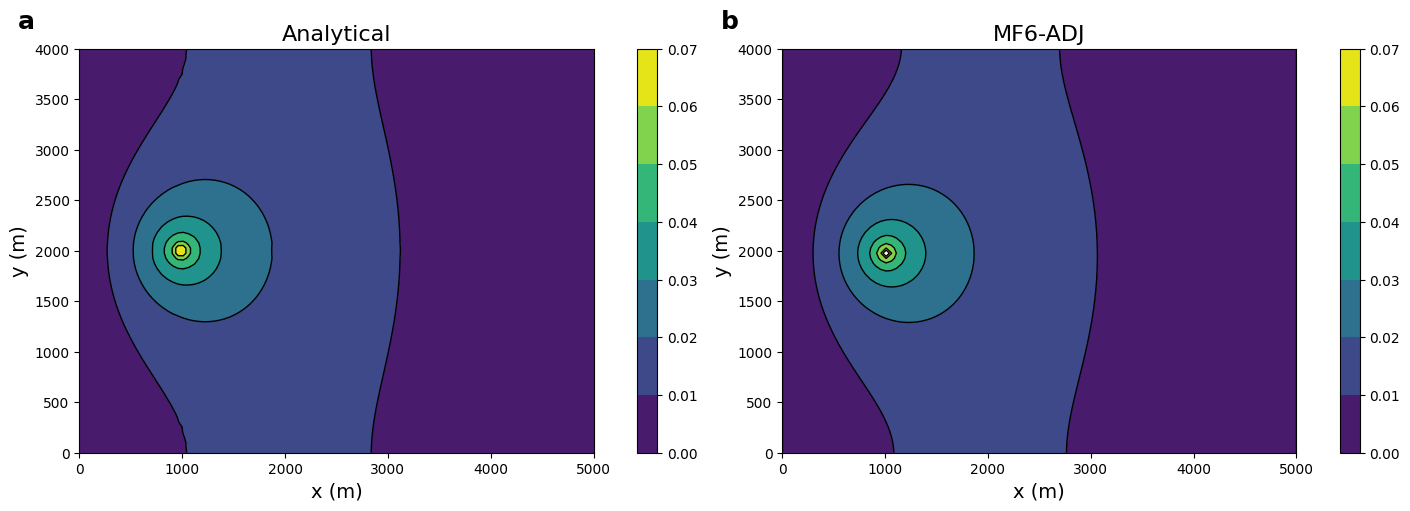

In [33]:
lam_adj = grp['wel6_q'][:]
x = np.linspace(0, L1, ncol)
y = np.linspace(0, L2, nrow)
x_center = [x[i] + delcol / 2. for i in range(len(x))]
y_center = [y[i] + delrow / 2. for i in range(len(y))]
y = y[::-1]
y_center = y_center[::-1]
vmin, vmax = lamb_ana.min(), lamb_ana.max()
contour_intervals = np.arange(vmin, vmax, 0.003)
plot_colorbar_contour(x, y, lamb_ana, lam_adj[0], vmin, vmax)